In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import tensorflow as tf

from src.data_worker import YOLODataset, init_COCO, DarknetTools
from src.utils import *
from src.disviz import setup_labels_plot

2023-02-28 12:25:10.542242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 12:25:10.614016: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Data Pipe for Background (Empty) Images
This notebook contains the code that I wrote to generate background images from photos of OSB board
that I took from the internet:
### Step 1
- Takes high resolution images and measures them against the target size, 576 x 768 (h x w).
- Resizes and Splits the image into equal parts.
- Outputs a Tensor object containing the generated background images.
### Step 2
- Performs some detection logic on the train dataset images that already exist
- Saves each image in the tensor to the train images directory
### Step 3
- Creates dictionary updates for the new images added to the train images directory
- Inserts updates into the dataset object for training data
- Updates the project directory by passing the new information through the `DarknetTools` Pipeline object.

In [2]:
np.set_printoptions(suppress=True, precision=4)
%load_ext autoreload

In [3]:
%autoreload 2
%aimport src.utils
%aimport src.disviz
%aimport src.data_worker

## Step 1
### Get the base images from which to generate backgrounds.

In [17]:
images = glob('./data/images/empty/*')
images = [cv.imread(img) for img in images]

#### Testing some of the logic for our sample function.

In [18]:
tar_size = [768, 576]
image = images[3]
image_area = np.cumsum(image.shape[:2])[-1]
tar_area = np.cumsum(tar_size)[-1]
result = image_area / tar_area

print(f"image: {image.shape}, {image.dtype}")
print(f"area_div: {result:.2f}")

image: (1597, 2390, 3), uint8
area_div: 2.97


### The background sampling function:

In [19]:
def bg_rand_sample(images, target_size):
    result = np.empty(shape=(0, 576, 768, 3), dtype=np.float32)
    for image in images:
        div = np.true_divide(np.array([image.shape[:-1]], dtype=np.int16),
                             np.array(target_size, dtype=np.int16), 
                             dtype=np.float32)
        div = np.array(np.around(div)[0], dtype=np.int32)
        new_size = np.array(div * target_size, dtype=np.int32)
        img = cv.resize(image, np.flip(new_size))
        img = np.asarray(np.split(img, div[0]))
        img = np.concatenate(np.split(img, div[1], axis=2), axis=0)
        if len(images) > 1:
            result = np.concatenate([result, img], axis=0)
        else:
            result = img
    return result

### Visualizing the result from our function.

In [20]:
result = bg_rand_sample([images[9]], target_size=[576, 768])
print(f"result: {result.shape}")

result: (6, 576, 768, 3)


In [31]:
def rowcol(data, base_size=(8, 6)):
    # get the number of images
    axes = data.shape[0]

    # calculate the cols (images per row) if displayed in a square grid
    cols = np.floor(np.sqrt(axes)).astype(np.int32)

    # calculate the rows by how many cols fit
    # if there is a remainder add one row
    rows, rem = np.divmod(axes, cols, dtype=np.int32)
    rows = rows + bool(rem) 

    ratio = base_size[1] / base_size[0]
    size = (base_size[0], ((base_size[0]/cols) * ratio ) * rows)
    
    return rows, cols, size

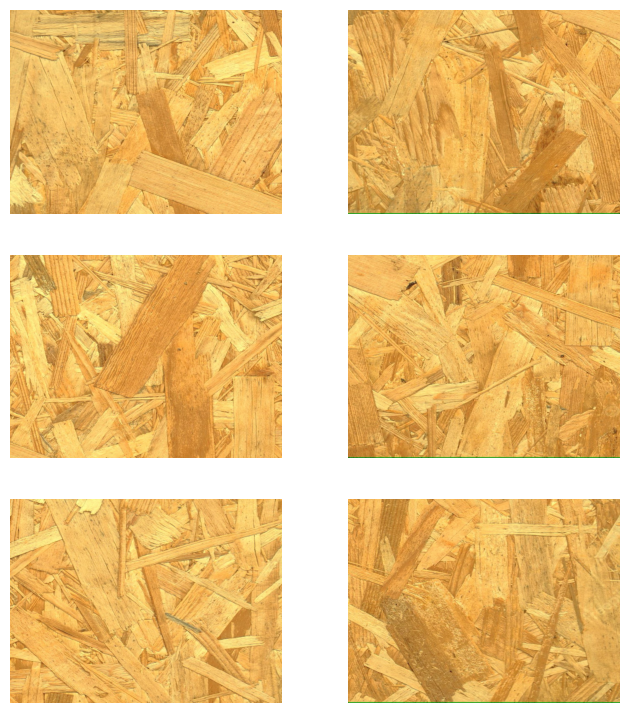

In [32]:
row, col, size = rowcol(result)
fig, ax = plt.subplots(row, col, figsize=size)
ax = ax.flat
for i in range(len(result)):
    ax[i].imshow(np.flip(result[i], axis=-1))
    ax[i].axis('off')
plt.show()

## Step 2
### Draw the background samples

In [ ]:
backgrounds = bg_rand_sample(images, target_size=[576, 768])
print(backgrounds.shape)

### Make a sorted list of all the image numbers currently in the train images directory

In [34]:
screws_num = sorted([int(x[-7:-4]) for x in glob('./data/images/train/screws_*.png')])
print(screws_num[-1])

384


### Save the background images to the train images directory
Some of the numbering here is a little extra. Before going through the whole process I wasn't
sure how the naming convention might affect data processing downstream, so there is a lot of
extra caution built in to avoid overwriting or conflicting with other data.

In [ ]:
count = screws_num[-1] + 10
for image in backgrounds:
    print(f"writing file {count:03d}")
    cv.imwrite(f'./data/images/train/screwsbg_{count:3d}.png', image)
    count += 1

## Step 3
### Initialize the dataset processing pipeline

In [4]:
data = init_COCO("./data/", ['train', 'val', 'test'])

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 269 train images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 55 val images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 60 test images


### Create a list of ids for each image in the training dataset

In [5]:
train_ids = list(range(1, len(glob('./data/images/train/*.png')) + 1, 1))
print(f"train_ids:\n{train_ids[:10]}\n...\n{train_ids[-10:]}")

train_ids:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
...
[403, 404, 405, 406, 407, 408, 409, 410, 411, 412]


In [10]:
train_ids[-len(bg_imgs)]

270

### Taking a look at the json data descriptions used to create image annotations

In [11]:
print(f"data: {data['train'].keys()}")
print(f"annotation_sample:")
data['train']['annotations'][-1], data['train']['img_data'][-1]

data: dict_keys(['coco', 'ids', 'img_data', 'annotations'])
annotation_sample:


({'area': 106663,
  'bbox': [197.1, 1018.68, 960.931, 111, 3.13785],
  'category_id': 2,
  'id': 269013,
  'image_id': 269,
  'is_crowd': 0},
 {'file_name': 'screwsbg_536.png',
  'height': 576,
  'width': 768,
  'id': 412,
  'license': 1})

### Create a sorted list of all the background images in the train images directory

In [8]:
bg_imgs = sorted([os.path.basename(x) for x in glob("./data/images/train/screwsbg_*.png")])
print(f"bg_imgs: {len(bg_imgs)}")

bg_imgs: 143


### Create the list of dictionary entries and add them to the COCO train dataset object

In [9]:
h = 576
w = 768
update = []
for id, img in zip(train_ids[-len(bg_imgs):], bg_imgs):
    update.append({'file_name': img,
                   'height': h,
                   'width': w,
                   'id': id,
                   'license': 1})
data['train']['img_data'].extend(update)

### Initialize the Dataset `Sequence` objects

In [12]:
train_dataset = YOLODataset(data_name='train',
                            coco_obj=data,
                            image_path='./data/images/',
                            input_size=(1440, 1920),
                            target_size=(576, 768))

getting images for train set:
Found 412 files belonging to 1 classes.


2023-02-28 12:25:57.530278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 12:25:57.532609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 12:25:57.532633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 12:25:57.533750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1026] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-28 12:25:57.533778: I tensorflow/com

In [13]:
val_dataset = YOLODataset(data_name='val',
                            coco_obj=data,
                            image_path='./data/images/',
                            input_size=(1440, 1920),
                            target_size=(576, 768))

getting images for val set:
Found 55 files belonging to 1 classes.


In [14]:
test_dataset = YOLODataset(data_name='test',
                            coco_obj=data,
                            image_path='./data/images/',
                            input_size=(1440, 1920),
                            target_size=(576, 768))

getting images for test set:
Found 60 files belonging to 1 classes.


### Initialize my Darknet data pipe class

In [35]:
darknet = DarknetTools(data=[train_dataset, val_dataset, test_dataset], image_size=[768, 576], project_directory='./darknet_yolo', make=True)

## Output the updated annotations for darknet training.

In [36]:
darknet.save_annotations()

# Finished
That's it. There is now a full set of background images included in the dataset to use for training
darknet. Make some tar balls, throw them in colab and have fun!